# Explore vs. exploit

Here, we investigate different strategies for how to make the suggestion for the next
point to sample.

This notebook is a part of the series about using ProcessOptimizer to guide a gold
mining expedition. For an overview, go to the markdown file gold_mining.md

## What we learned last time
We define our map by setting `coordinates`, and our `score()` function. We then
initialise a ProcessOptimizer on the `coordinates`. We then do 10 cycles of asking for
a place to dig, sending Ms. Dixon's team to dig, and telling the ProcessOptimizer how
much gold was found.

Lastly, we plot the **secret** gold map, so we can evaluate whether the models built
look like the actual scoring function.

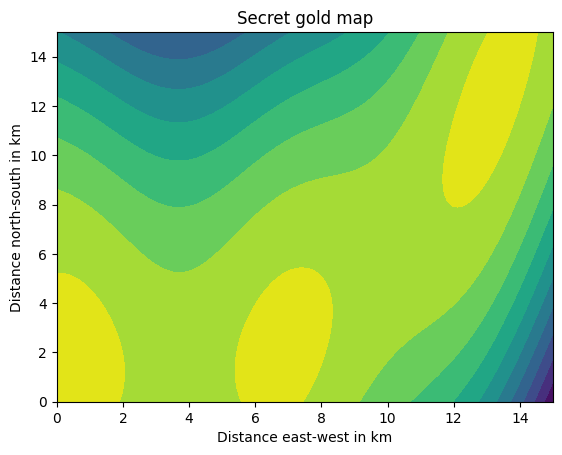

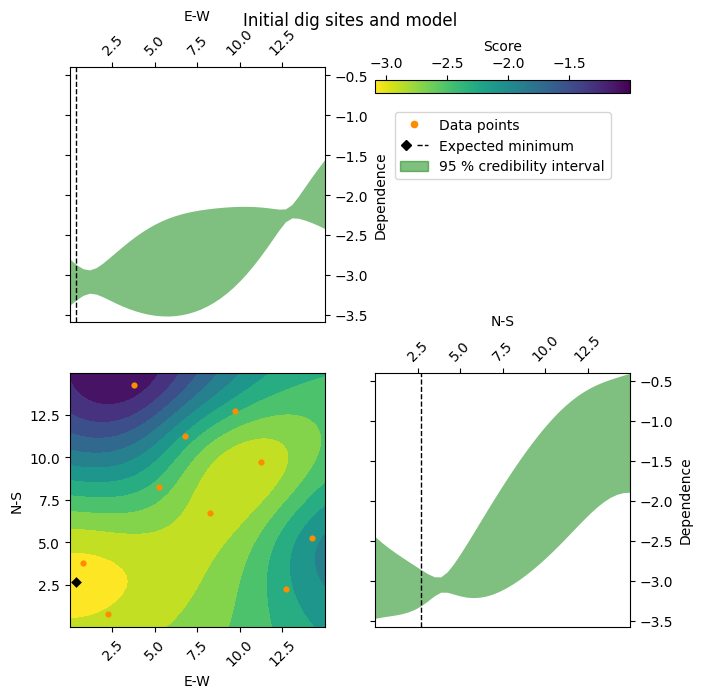

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import ProcessOptimizer
from ProcessOptimizer.model_systems import gold_map

#Setting random seed to ensure reproducible behaviour
np.random.seed(42)

VERBOSE = False

coordinates = [(0, 15.0),(0,15.0)]

num_digs = 10

opt = ProcessOptimizer.Optimizer(dimensions=coordinates)
# For each of the first 10 positions
for index in range(10):
    # Find the place to dig
    new_dig_site = opt.ask()
    # Digging for gold
    gold_found = gold_map.get_score(new_dig_site)
    # Telling the optimiser how uch gold we found
    result = opt.tell(new_dig_site, gold_found)

#Plotting the secret map
# Making the lists of x and y coordinates
x_list = np.linspace(coordinates[0][0],coordinates[0][1],100)
y_list = np.linspace(coordinates[1][0],coordinates[1][1],100)

(x_mesh,y_mesh) = np.meshgrid(x_list,y_list)
score_mesh = [[-gold_map.score((x,y)) for (x,y) in zip(x_vec,y_vec)] 
              for (x_vec,y_vec) in zip(x_mesh,y_mesh)]
plot = plt.contourf(x_mesh,y_mesh,score_mesh,10)
plot.axes.set_xlabel("Distance east-west in km")
plot.axes.set_ylabel("Distance north-south in km")
plot.axes.set_title("Secret gold map")
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"],title="Initial dig sites and model");

## What to value when picking the next point

The next time Ms. Dixon goes to the office, she gets into an argument with a colleague,
Mr. Map Drawson. Ms. Dixon wants dig where she expects to find the most
gold, while Mr. Drawson wants to plan for a bigger operation later, so he is more
interested in the knowledge the dig gives them of where the gold is in the plot of land.

These two approaches is known as **Exploit** (Ms. Dixons's approach), where we value
getting a good result over getting more knowlegde, and **Explore** (Mr. Drawsons's
approach), where we value reducing uncertainties about how good different parameter
settings are. It isn't a dichotomy where we have to choose one or the other, we can
choose different balances between the two considerations.

The balance is determined by the property of ProcessOptimizer `acq_func_kwargs`, which
is a `dict`. In the default ProcessOptimizer, the value of `acq_func_kwargs["xi"]`
determines where the balance lies. the lower the value, the more exploiting the
ProcessOptimizer becomes.

Let's first run it with an intermediate setting, where `xi = 0.3`, so we have something to
compare the other settings to.

Intermediate ProcessOptimizer found 2.681158897493202 mg of gold on average


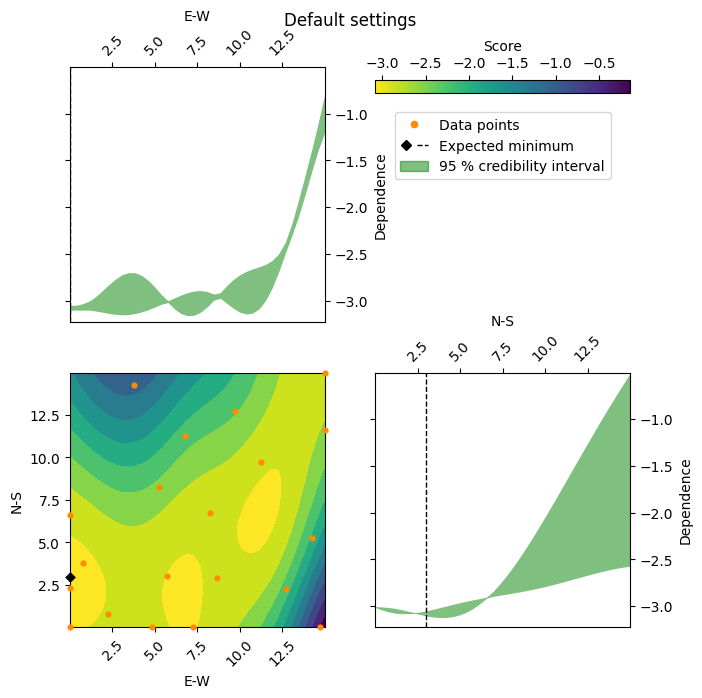

In [10]:
default_opt = opt.copy()
default_opt.acq_func_kwargs = {"xi": 0.3}
default_opt.update_next()
total_gold_found = 0
for _ in range(num_digs):
    new_point = default_opt.ask()
    gold_found = gold_map.get_score(new_point)
    total_gold_found += gold_found
    result = default_opt.tell(new_point,gold_found)
print(f"Intermediate ProcessOptimizer found {-total_gold_found/num_digs} mg of gold on average")
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"],title="Default settings");

## Exploiting

Now let's try and let Ms. Dixon decide where to dig; That is, using a more exploiting
ProcessOptimizer. To do this, we set `xi` lower than the default.

Exploiting ProcessOptimizer found 2.9856170692303388 mg of gold on average


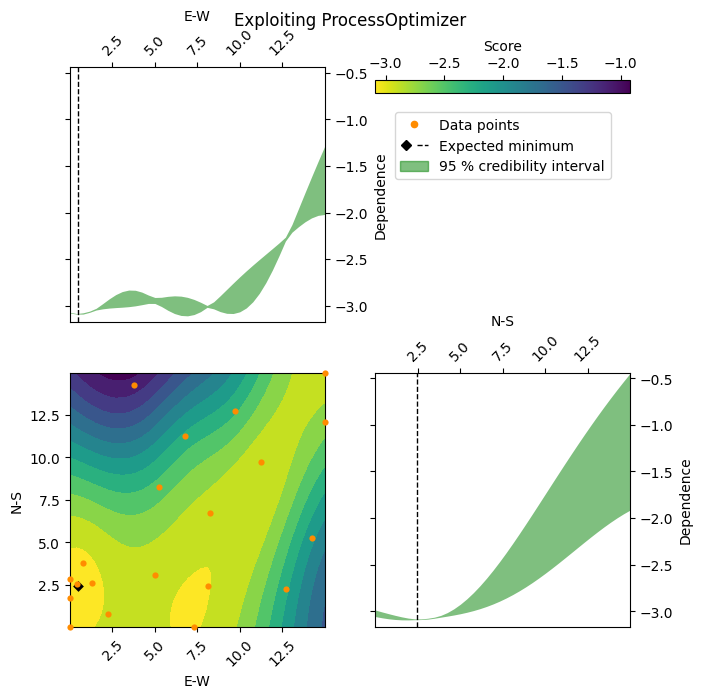

In [11]:
exploiting_opt = opt.copy()
exploiting_opt.acq_func_kwargs = {"xi": 0.00001}
exploiting_opt.update_next()
total_gold_found = 0
for _ in range(num_digs):
    new_point = exploiting_opt.ask()
    gold_found = gold_map.get_score(new_point)
    total_gold_found += gold_found
    result = exploiting_opt.tell(new_point,gold_found)
print(f"Exploiting ProcessOptimizer found {-total_gold_found/num_digs} mg of gold on average")
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"], title="Exploiting ProcessOptimizer");


Notice that the average amount of gold found is higher than for the first
ProcessOptimiser, if only slightly so; the default optimizer is pretty good at only 
digging at optimal places for this score function (the secret gold map). On the other
hand, there is much less overall knwoledge of where to find gold. The optimum in the
upper right is missign from the model.

So the exploiting ProcessOptimizer is less adventurous, but tends to give better results
for the parameters is suggest.

## Exploring

Now let's try and build an exploring ProcessOptimizer instead. To do this, we set `xi`
higher than for the first ProcessOptimizer

Exploring ProcessOptimizer found 2.318637225692494 mg of gold on average


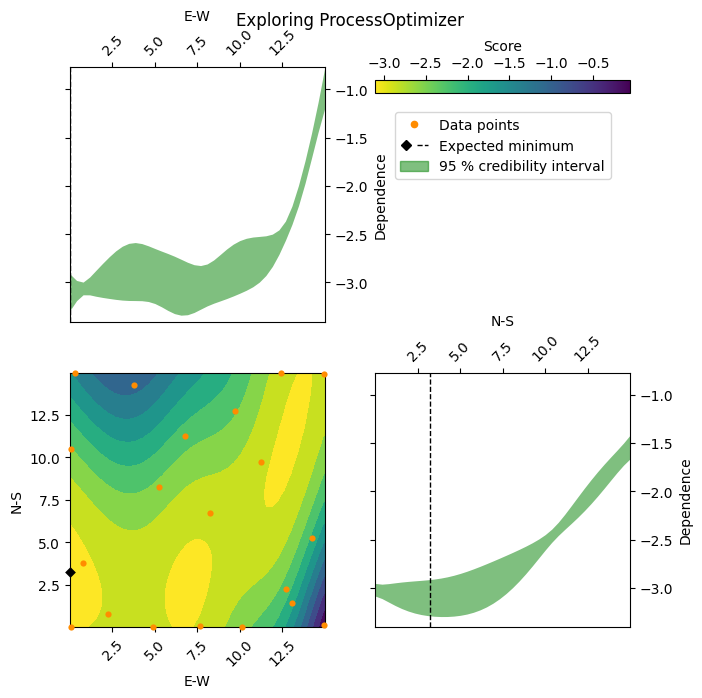

In [12]:
exploring_opt = opt.copy()
exploring_opt.acq_func_kwargs = {"xi": 10}
exploring_opt.update_next()
total_gold_found = 0
for _ in range(num_digs):
    new_point = exploring_opt.ask()
    gold_found = gold_map.get_score(new_point)
    total_gold_found += gold_found
    result = exploring_opt.tell(new_point,gold_found)
print(f"Exploring ProcessOptimizer found {-total_gold_found/num_digs} mg of gold on average")
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"], title="Exploring ProcessOptimizer");


The average amount of gold found is lower. You an also see that the digs are more spread
out that for the default. This is because the model had high uncertainty in these areas,
so even if it predicted that little gold would be found, the small chance that a lot of
gold was present here made the exploring ProcessOptimizer suggest digging there.

The map is much more accurate than it was for the other two ProcessOptimizers

## Conclusion

Changing the explore-exploit balance can significantly affect the outcome of
ProcessOptimizer. It is important the consider whether you are more interested in
finding a good spot, or finding all of the good areas, and to set the axplore-exploit
balance accordingly.